# <center> Introduction to Machine Learning with TensorFlow</center>
## <center> Supervised Learning</center>
## <center> Project: Finding Donors for `CharityML` </center>

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#Explore">Exploring the data </a></li>
    - <a href="#init">Initial Stats </a><br>
    - <a href="#featureset">Featureset Exploration </a><br>
<li><a href="#Prepare">Preparing the data</a></li>
    - <a href="#tran">Transforming Skewed Continuous Features </a><br>
    - <a href="#norm">Normalizing Numerical Features </a><br>
    - <a href="#ohe">One-hot Encoding </a><br>
    - <a href="#sh">Shuffle and Split Data </a><br>
    
<li><a href="#Evaluate">Evaluating Model Performance</a></li>
    - <a href="#Metrics">Metrics and the Naive Predictor </a><br>
    - <a href="#NaivePer">Naive Predictor Performace </a><br>
    - <a href="#Supervised">Supervised Learning Models </a><br>
    - <a href="#App">Model Application </a><br>
    - <a href="#pipe">Creating a Training and Predicting Pipeline </a><br>
    - <a href="#init_eval">Initial Model Evaluation </a><br>
    
    
<li><a href="#Improve">Improving the results</a></li>
    - <a href="#Best"> Choosing the best model </a><br>
    - <a href="#Describe"> Describing the Model in Layman's Terms</a><br>
    - <a href="#Tuning"> Model Tuning</a><br>
    - <a href="#Final_Eval"> Final Model Evaluation</a><br>
  
<li><a href="#Feature">Feature Selection</a></li>
    - <a href="#f_obs"> Feature Relevance Observation </a><br>
    - <a href="#f_ext"> Extracting Feature Importance</a><br>
    - <a href="#f_sel"> Feature Selection</a><br>
    - <a href="#f_eff"> Effects of Feature Selection</a><br>

<li><a href="#kaggle">Kaggle Submission</a></li>
    - <a href="#check"> Check missing data </a><br>
    - <a href="#deal"> Dealing with missing values</a><br>
    - <a href="#write"> Write the output file </a><br>
<li><a href="#Conc">Conclusion and future work</a></li>
</ul>

<a id = "intro"></a>
## Introduction

In this project, we **_employ several supervised algorithms_** to accurately model individuals' income using data collected from the 1994 U.S. Census. Having _compare those elementary approaches to a naive predictor_, we choose the best candidate algorithm from preliminary results and **_further optimize this algorithm to best model the data_**. _**<u>Our goal</u>**_ with this implementation is to **construct a model that accurately predicts whether an individual makes more than `$50,000`**. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. _**<u>Finally</u>**_, we prepare a submission file to participate in [Udacity ML Charity Competition](https://www.kaggle.com/c/udacity-mlcharity-competition/overview).

`CharityML` is a fictitious charity organization located in the heart of Silicon Valley that was established to provide financial support for people eager to learn machine learning. After nearly `32,000` letters were sent to people in the community, `CharityML` determined that every donation they received came from someone that was making more than `$50,000` annually. To expand their potential donor base, `CharityML` has decided to send letters to residents of California, but to only those most likely to donate to the charity. With nearly 15 million working Californians, `CharityML` needs to build an algorithm to best identify potential donors and reduce overhead cost of sending mail. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
# Import supplementary visualization code visuals.py
import visuals as vs
from dython.nominal import associations
# Pretty display for notebooks
%matplotlib inline
submit = False

<a id = "Explore"></a>
----
## Exploring the Data

In [2]:
# Load the Census dataset
data = pd.read_csv("census.csv")
data_comp = pd.read_csv('test_census.csv' , index_col = [0])
# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


<a id = 'init'></a>
### Initial Stats
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than `$50,000`.

In [3]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data.query("income == '>50K'").shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.query("income == '<=50K'").shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:1.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


<a id = "featureset"></a>
### Featureset Exploration 


#### Pre-observations

It can be shown that out of the existing 13 features, the dataset has 5 numerical (continuous) as well as 8 categorical features. More details below

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

It is quite uesful to look up different relationships in our data to gain some insights before digging in the details of the preprocessing. One way to do so is to explore the corrleation between different features. However, It is a little tricky to do so using conventional libiraries with catergorical features despite its importance. One useful package for this purpose can be found [here](https://github.com/shakedzy/dython) where all the documentation and installation instructions can be found. Here, we need to find association between different features including categorical features. 

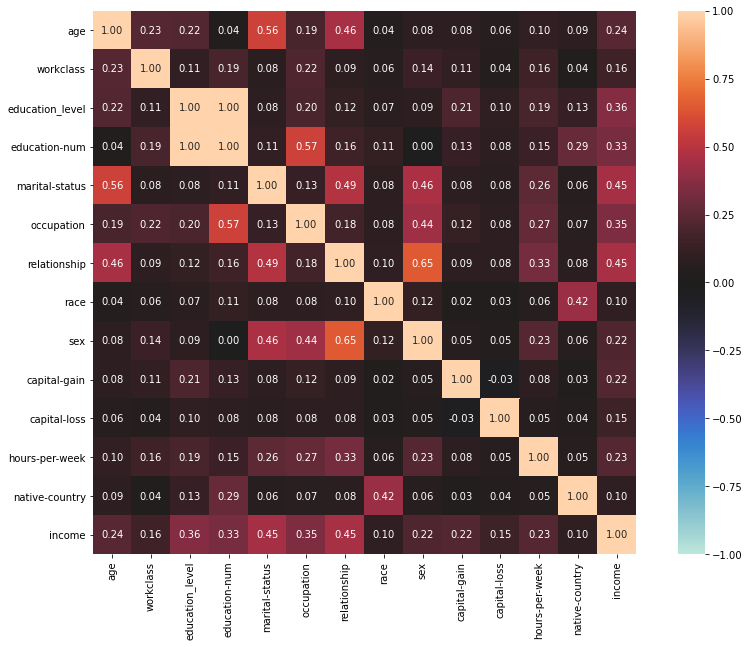

In [4]:
M = associations(data,figsize = (15,10))

This matrix will be used in <a href="#f_obs"> Feature Relevance Observation </a> when we discuss the rank of feature importances.  

<a id = "Prepare"></a>
----
## Preparing the Data
Before the data can be used as an input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

<a id ="tran"></a>
### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

D:\ML\courses\MachineLearningWithTF\codes\projects\p1_charityml\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


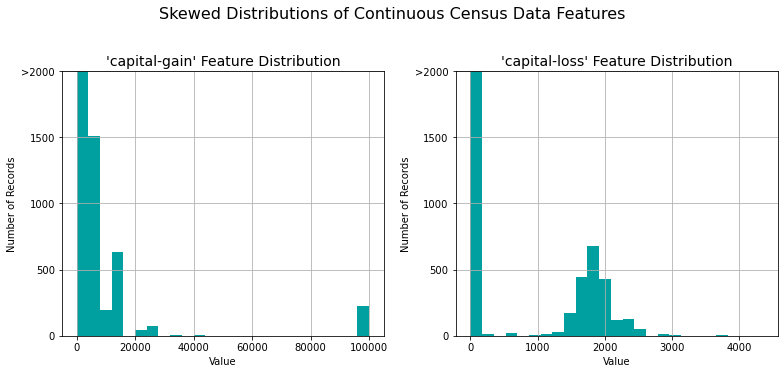

In [5]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

features_raw_comp = data_comp
# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

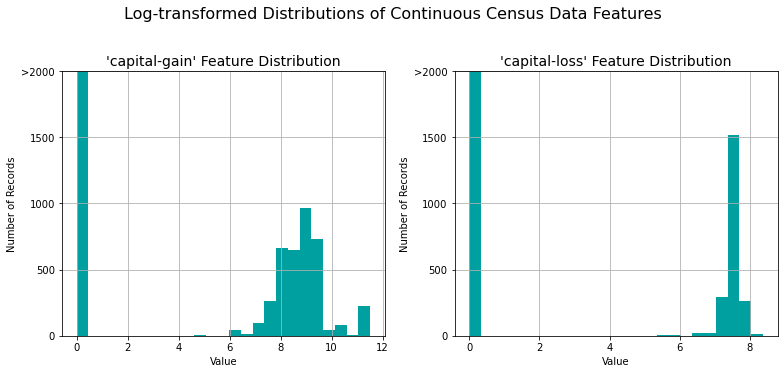

In [6]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))


features_log_transformed_comp = pd.DataFrame(data = features_raw_comp)
features_log_transformed_comp[skewed] = features_raw_comp[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

<a id = "norm"></a>
### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to normalize each numerical feature.

In [7]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

features_log_minmax_transform_comp = pd.DataFrame(data = features_log_transformed_comp)
features_log_minmax_transform_comp[numerical] = scaler.fit_transform(features_log_transformed_comp[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


<a id = "ohe"></a>
### One-hot Encoding

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [8]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

features_final_comp = pd.get_dummies(features_log_minmax_transform_comp)
# Encode the 'income_raw' data to numerical values
income = [0 if  i == '<=50K' else 1 for i in income_raw]

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print (encoded)

103 total features after one-hot encoding.


<a id = "sh"></a>
### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [9]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


<a id ="Evaluate"></a>
----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

<a id = "Metrics"></a>
### Metrics and the Naive Predictor
`CharityML`, equipped with their research, knows individuals that make more than `$50,000` are most likely to donate to their charity. Because of this, `CharityML` is particularly interested in predicting who makes more than `$50,000` accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than `$50,000` as someone who does would be detrimental to `CharityML`, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most `$50,000`, and those who make more), it's clear that most individuals do not make more than `$50,000`. This can greatly affect **accuracy**, since we could simply say "this person does not make more than `$50,000`" and generally will be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than `$50,000`, `CharityML` would identify no one as donors.

#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of true positives, actually were true positives.
It is a ratio of true positives(indviduals classified as making more than `$50,000` , and which are actually make) to all positives(all wealthy people, irrespective of whether that was the correct classification), it can be expressed as 

<center> $Precision=\ \frac{True\ positives}{True\ positives+False\ positives} $ </center>

**Recall(sensitivity)** tells us what proportion of people that actually were wealthy were classified by us as wealthy.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

<center> $Recall=\ \frac{True\ positives}{True\ positives + False\ negatives} $ </center>

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is the weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

<a id = "NaivePer"></a>
### Naive Predictor Performace
If we choose a model that always predict an individual make more than $50,000, we are going to explore what would  that model's accuracy and F-score be on this dataset.

The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally the base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

In [10]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
TP = np.sum(income)
FP = len(income) - TP 
TN = 0
FN = 0 

accuracy = (TP + TN)/(TP + FP + TN + FN)
recall = (TP) / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = .5
fscore = (1+ beta**2) * (precision * recall) / (beta **2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


<a id = "Supervised"></a>
###  Supervised Learning Models

<a id = "App"></a>
### Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

In [11]:
from IPython.display import display, HTML

def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

Models_Comparison = pd.DataFrame(columns = ['SVM', 'Random Forest','Naive Bayes'], 
                                 index = ['Real World Application', 'Pros', 'Cons', 'Candidacy for this data'])

Models_Comparison.at['Real World Application', 'SVM'] = 'Image Classifiers'
Models_Comparison.at['Real World Application', 'Random Forest'] = 'Recommendation Systems'
Models_Comparison.at['Real World Application','Naive Bayes'] = 'Spam Classifiers'

Models_Comparison.at['Pros','SVM'] = u"\u2022 Kernels\n\u2022 Maximize Boundaries"
Models_Comparison.at['Pros','Naive Bayes'] = u"\u2022 Ability to handle an extremely large number of features\n\
\u2022 Performs well even with the presence of irrelevant features\n\
\u2022 Simple, rarely need to tune its parameters\n\
\u2022 It rarely ever overfits the data\n\
\u2022 Fast training and prediction times"
Models_Comparison.at['Pros', 'Random Forest'] = u"\u2022 Not sensitive to outliers\n\
\u2022 Handles both categorical and continuous data"

Models_Comparison.at['Cons','SVM'] = u"\u2022 Sensitive to outliers i.e. when target classes are overlapping"
Models_Comparison.at['Cons', 'Random Forest'] = u"\u2022 Prone to over fitting"
Models_Comparison.at['Cons', 'Naive Bayes'] = u"\u2022 Vanishing values due to multiplication of small probabilities"

Models_Comparison.at['Candidacy for this data', 'SVM']= u"\u2022 Ability to handle non-linear relationships." 
Models_Comparison.at['Candidacy for this data', 'Random Forest']= u"\u2022 It can handle categorical features effectively."
Models_Comparison.at['Candidacy for this data', 'Naive Bayes']= u"\u2022 Fast but accurate classifier."

References = ['https://medium.com/@anuuz.soni/pros-and-cons-of-naive-bayes-classifier-40b67249ae8',
             'https://data-flair.training/blogs/applications-of-svm/',
             'https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/',
             'https://towardsai.net/p/machine-learning/why-choose-random-forest-and-not-decision-trees']

pretty_print(Models_Comparison)

,SVM,Random Forest,Naive Bayes
Real World Application,Image Classifiers,Recommendation Systems,Spam Classifiers
Pros,• Kernels• Maximize Boundaries,• Not sensitive to outliers• Handles both categorical and continuous data,"• Ability to handle an extremely large number of features• Performs well even with the presence of irrelevant features• Simple, rarely need to tune its parameters• It rarely ever overfits the data• Fast training and prediction times"
Cons,• Sensitive to outliers i.e. when target classes are overlapping,• Prone to over fitting,• Vanishing values due to multiplication of small probabilities
Candidacy for this data,• Ability to handle non-linear relationships.,• It can handle categorical features effectively.,• Fast but accurate classifier.


<a id = "pipe"></a>
### Creating a Training and Predicting Pipeline
To properly evaluate the performance of chosen models, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. This implementation will be used in the following section.

In the code block below, we implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.


In [12]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train.iloc[0:sample_size+1, :], y_train[0:sample_size+1])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train.iloc[0:300, :])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(predictions_train[0:300], y_train[0:300])
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(predictions_train[0:300], y_train[0:300], beta = .5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(predictions_test, y_test, beta = .5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

<a id = "init_eval"></a>
### Initial Model Evaluation
In the next code cell, we implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model if provided.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


D:\ML\courses\MachineLearningWithTF\codes\projects\p1_charityml\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


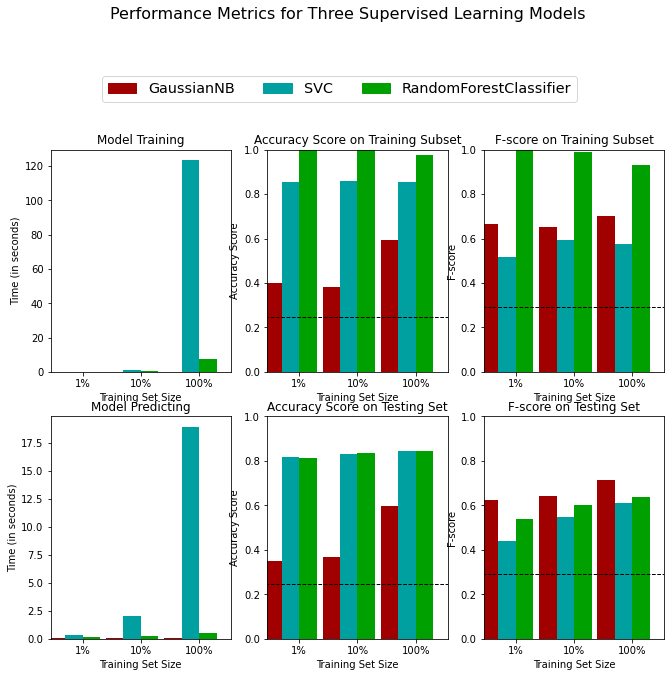

In [13]:
# Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Initialize the three models
clf_A = GaussianNB()
clf_B = SVC(random_state = 42)
clf_C = RandomForestClassifier(random_state = 42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(y_train)
samples_10 = int(.1 * samples_100)
samples_1 = int(.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, s in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, s, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [14]:
AllDataResults = []
for m in results.keys():
    AllDataResults.append([results[m][2].get(key) for key in ['acc_test','f_test','pred_time']])

AllDataResults = pd.DataFrame(AllDataResults, index = results.keys(), columns = ['Accuracy test', 'F test', 'Prediction time (s)'])
AllDataResults

,Accuracy test,F test,Prediction time (s)
GaussianNB,0.597678,0.713340,0.037957
SVC,0.842344,0.610490,18.884746
RandomForestClassifier,0.842344,0.637795,0.475477


<a id = "Improve"></a>
----
## Improving Results
Based on the initial results above, we choose the *best* model to use on the given data. Then, we perform a grid search optimization for this model over the entire training set (`X_train` and `y_train`) to improve upon the untuned model's F-score. 

<a id = 'Best'></a>
### Choosing the Best Model

Based on the initial model evaluation results on the full data ,the `RandomForestClassifier` successfully prove its capability to produce more percise prediction in a little prediction time for large number of samples. Furthermore, the data has a lot of outliers which can be easily handled by tree-based models. Besides, the data has a lot of categorical features which can be another good reason to select tree models.  _For these reasons_, we select it as our best model.  

<a id = 'Describe'></a>
### Describing the Model in Layman's Terms

`RandomForestClassifier` exploits the power of aggregating multiple weak classifiers in such a way to construct a strong classfier. By assigning a random small set of features to each learner, it can be able to learn the patterns hidden in those columns. Taking the teamwork of many trees thus improving the performance of a single random tree <sup>[Random forest](https://en.wikipedia.org/wiki/Random_forest).</sup> Basically, the weak learner is a decision tree which group similar data together based on a spicific condition. For example, the tree might want to divide the data points based on the education level feature and build further decisions upon completing this grouping. As a concrete example, if the data point has a bachelor degree then this point has more potential to have income greater than required threshold.   

<a id = 'Tuning'></a>
### Model Tuning
Finally, we perform a grid search on the selected model to fine tune its parameters to improve the results as much as possible. 

**Note:** The following implementation may take several minutes to run!

In [15]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# Initialize the classifier
clf = RandomForestClassifier(random_state = 42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators' : [100, 200, 500] , 'max_depth' : [2,4,10], 'min_samples_split': [8,20], 
             'min_samples_leaf': [5,15]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf, scoring = scorer, param_grid = parameters,verbose = 1,n_jobs = 2)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:  8.9min finished


In [16]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8423
F-score on testing data: 0.6813

Optimized Model
------
Final accuracy score on the testing data: 0.8548
Final F-score on the testing data: 0.7264


<a id = 'Final_Eval'></a>
### Final Model Evaluation

After a long time of searching, we managed to increase the overall performance of our model a little bit. The optimized model over perform the unoptimized model in both accuracy and F-score. Furthermore, the fine-tuned model super outperforms the naive predictor used as our baseline model.

In [17]:
FinalResults = pd.DataFrame(data = [[accuracy *100, accuracy_score(y_test, predictions)*100, accuracy_score(y_test, best_predictions) * 100],
                               [fscore, fbeta_score(y_test, predictions, beta = 0.5), fbeta_score(y_test, best_predictions, beta = 0.5)]],
                      index = ['Accuracy Score (%)', 'F-score [0 - 1]'], columns = ['Baseline Model', 'Unoptimized Model', 'Optimized Model'])
FinalResults

,Baseline Model,Unoptimized Model,Optimized Model
Accuracy Score (%),24.784397,84.234384,85.483693
F-score [0 - 1],0.291729,0.681346,0.726353


The best parameters found are

In [18]:
best_clf

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20,
                       n_estimators=200, random_state=42)

<a id= "Feature"></a>
----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than `$50,000`.

<a id = 'f_obs'></a>
### Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. But of these thirteen records, which five features can we expect to be most important for prediction, and in what order can we rank them and why?

_To answer this question_, we refer back to assoication matrix calculated in <a href="#featureset">Featureset Exploration </a>. Thus, we can expect the top 5 relevant features to be

In [19]:
income_corr = M['corr'].loc['income']
values = income_corr[np.argsort(income_corr)[::-1]]
values[1:6]

relationship       0.454761
marital-status     0.448671
education_level    0.363678
occupation         0.345631
education-num      0.332800
Name: income, dtype: float64

Intuitively, the `education level` as well as `education number` increase the person's cabability to land respectful jobs so it is logical that they are related to the target. In addition, the `occupation` provides helpful information about the current job which can be a good indicator too. Finally, the `marital status` and `relationship` can be a good indicator of the person maturity as well as current responsbilities which can provide helpful insights too. 

<a id = 'f_ext'></a>
### Extracting Feature Importance

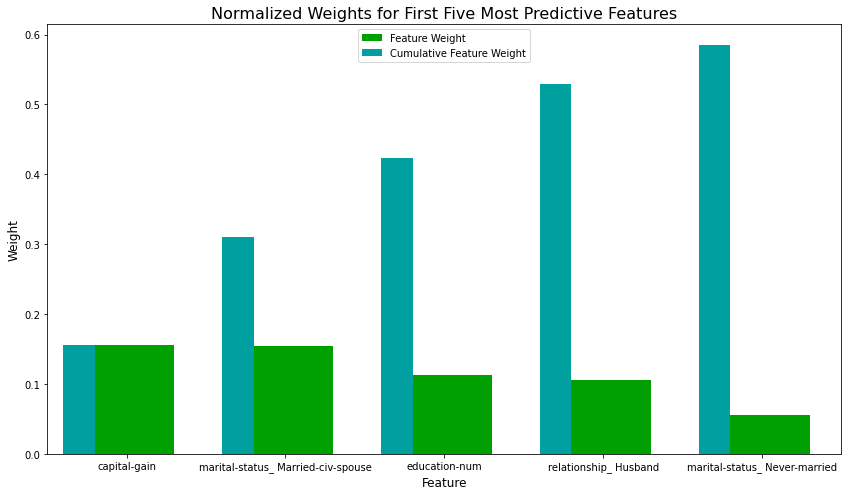

In [20]:
# Extracting the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [21]:
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
columns

array(['capital-gain', 'marital-status_ Married-civ-spouse',
       'education-num', 'relationship_ Husband',
       'marital-status_ Never-married'], dtype=object)

#### Extracted Features Vs observed 

The `RandomForestModel` agreed with our observation about importance of `Marital Status` as well as `education number` and `relationship` features. Furthermore, the model estimated which specific category of each of those features is the most important. For example, model assessed that Husband category can influence the prediction more than any other categories in relationships. However, the model differ with our observation about `occupation` and `education level`. Instead, it priortize the `capital gain` as well as `age` columns.

<a id = 'f_sel'></a>
### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [22]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8548
F-score on testing data: 0.7264

Final Model trained on reduced data
------
Accuracy on testing data: 0.8457
F-score on testing data: 0.7025


<a id = 'f_eff'></a>
### Effects of Feature Selection

As expected, the feature selection worsen the performance a little bit but since we used more than half of the available information, we can see that final model do pretty well job on the reduced data. However, considering the tiny amount of time needed to train `RandomForestClassifiers`, we actually don't need this compromise. It can be useful if we selected `Support Vector Classifiers` because of their heavy training time. 

<a id = 'kaggle'></a>
## Kaggle Submission 

<a id = 'check'></a>
### Check missing data

In [23]:
features_final_comp.isna().sum()

age                                17
education-num                      14
capital-gain                       15
capital-loss                       17
hours-per-week                     13
                                   ..
native-country_ Thailand            0
native-country_ Trinadad&Tobago     0
native-country_ United-States       0
native-country_ Vietnam             0
native-country_ Yugoslavia          0
Length: 103, dtype: int64

<a id = 'deal'></a>
### Dealing with missing values 

Since the test data contain some missing values, we need deal with this problem in order to predict all required users. A lot of methods are available to fill the missing values using the available data in this columns in case of small number of missing values. In our case, we fill the missing values by the _median values_ of corresponding columns. 

In [24]:
features = [k for k,v in features_final_comp.isna().sum().items() if v>0]
features_final_comp.fillna(features_final_comp[features].median(),inplace = True)
features_final_comp.isna().sum()

age                                0
education-num                      0
capital-gain                       0
capital-loss                       0
hours-per-week                     0
                                  ..
native-country_ Thailand           0
native-country_ Trinadad&Tobago    0
native-country_ United-States      0
native-country_ Vietnam            0
native-country_ Yugoslavia         0
Length: 103, dtype: int64

<a id = 'write'></a> 
### Write the output file

In [25]:
y_comp = best_clf.predict(features_final_comp)
final_frame = pd.DataFrame(data = np.array([features_final_comp.index, y_comp]).T, columns = ['id', 'income'])
if submit:
    print('Updating submission file...')
    final_frame.to_csv( 'Latestsubmission_P.csv', header = True , index = False)
    print('Updating submission file Done!')

<a id ="Conc"></a>
## Conclusion and future work

A strong way to enhance your data science as well as machine learning skills is to participate in Kaggle competitions where you can practice the end-to-end process and see where you are stand in the leaderboard. This can be a strong motivation to keep improving your skills in order to compete effectively. In this notebook, we experienced the complexity of machine learning pipeline by applying several techniques on a real-world dataset. At the end of the day, we achieved a score of `76%` on the test data associated with this competition . A lot of work still needed on the pre-processing stage in order to enhance our score. 